In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import keras.backend as K

import ModelBuilder

In [2]:
def flatten(t):
    return np.array([item for sublist in t for item in sublist])

In [3]:
EPOCHS = 50   # 1e3
REF    = 200  # 1e3
BKG    = 3    # 1e3
WCLIP  = 4
NTOYS  = 1

RUNS = [1253, 1265, 1242]
TEST = 4

t_lists = []
t_histories = []

DATA_FOLDER = f"/lustre/cmswork/nlai/DRIFT_TIME/model_testing/"
FOLDER_0 = f"shot_E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[0]}"
FOLDER_1 = f"shot_E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[1]}_test{TEST}"
FOLDER_2 = f"shot_E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[2]}_test{TEST}"
OUT_PATH_0 = DATA_FOLDER + FOLDER_0
OUT_PATH_1 = DATA_FOLDER + FOLDER_1
OUT_PATH_2 = DATA_FOLDER + FOLDER_2

# REFERENCE
path = "/lustre/cmswork/nlai/DATA/"
name = "t_reference.txt"
t_list_ref = np.loadtxt(fname=path+name)

In [4]:
distributions_path = "/lustre/cmswork/nlai/FALKON/data/"

df_ref    = pd.read_csv(distributions_path+ "RUN1252.txt")
df_data_0 = pd.read_csv(distributions_path+f"RUN{RUNS[0]}.txt")
df_data_1 = pd.read_csv(distributions_path+f"RUN{RUNS[1]}.txt")
df_data_2 = pd.read_csv(distributions_path+f"RUN{RUNS[2]}.txt")

In [5]:
w_ref    = flatten(np.ones_like(df_ref))
w_data_0 = flatten(np.ones_like(df_data_0))
w_data_1 = flatten(np.ones_like(df_data_1))
w_data_2 = flatten(np.ones_like(df_data_2))

w_ref_0  = w_ref*df_data_0.shape[0]/df_ref.shape[0]
w_ref_1  = w_ref*df_data_1.shape[0]/df_ref.shape[0]
w_ref_2  = w_ref*df_data_2.shape[0]/df_ref.shape[0]

bins = np.linspace(-190, 590, 90)

In [6]:
data_df    = [df_data_0,    df_data_1,    df_data_2   ]
w_data     = [w_data_0,     w_data_1,     w_data_2    ]
w_refs     = [w_ref_0,      w_ref_1,      w_ref_2     ]

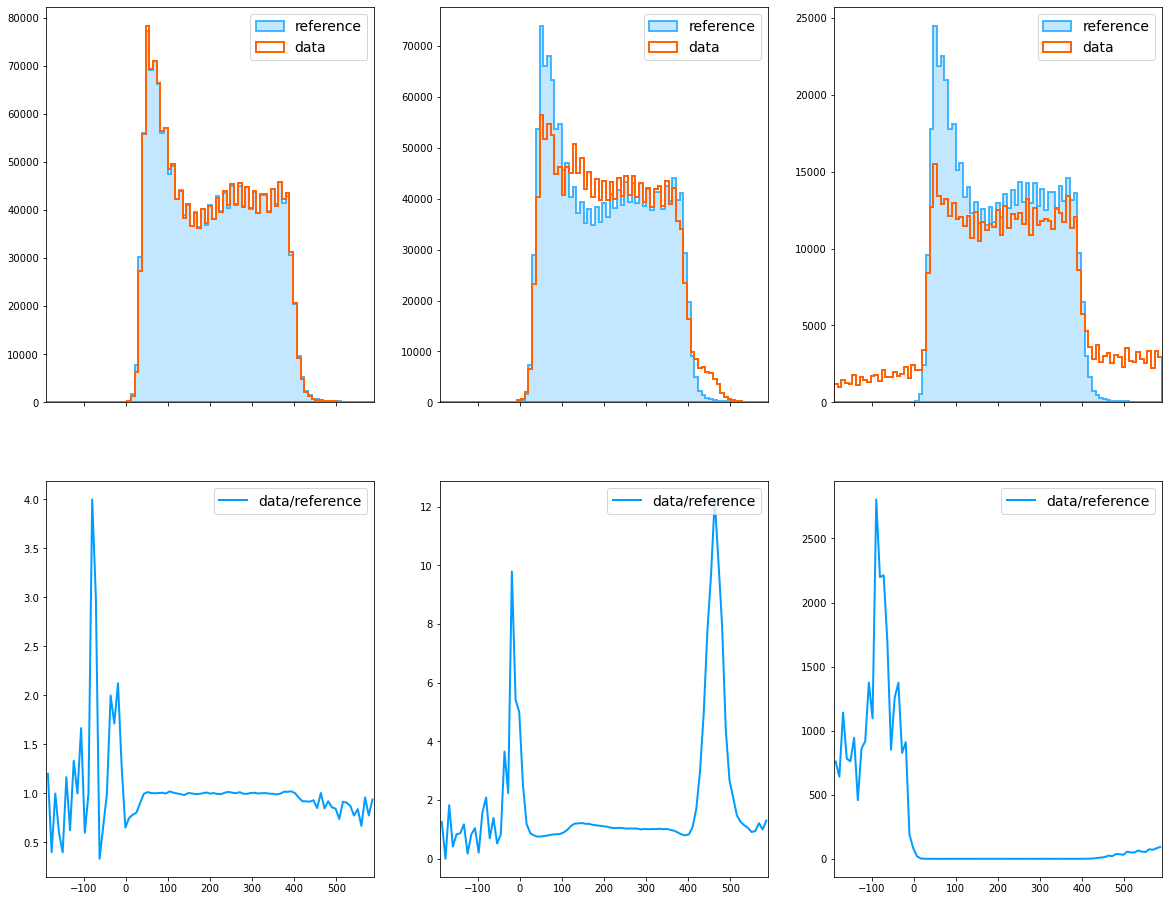

In [7]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,16), sharex="all")

ax[0][0].set_xlim(-190,590)
x = 0.5*(bins[1:]+bins[:-1])

for i in [0, 1, 2]:
    
    # reference distribution
    ref_hist = ax[0][i].hist(
        df_ref["drift_time"], 
        bins=bins, 
        weights=w_refs[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="#009cff", 
        facecolor="#aadeff", 
        alpha=.7, 
        label="reference"
    )
    
    # data distribution
    data_hist = ax[0][i].hist(
        data_df[i]["drift_time"], 
        bins=bins, 
        weights=w_data[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="#FF6104", 
        facecolor="none", 
        alpha=1, 
        label="data"
    )
    
    ax[0][i].legend(loc="upper right", fontsize=14)
    
    # data/ref ratio
    ax[1][i].plot(
        x, 
        (data_hist[0])/(ref_hist[0]),
        linewidth=2,
        color="#009cff", 
        alpha=1, 
        label="data/reference"
    )
    
    ax[1][i].legend(loc="upper right", fontsize=14)

plot_name = "distributions"
ext = "pdf"
fig.savefig(
    f"/lustre/cmswork/nlai/FALKON/plots/{plot_name}.{ext}",
    facecolor="white"
)   
plt.show()

In [8]:
NPLModel = ModelBuilder.ModelBuilder(
            n_input=1,
            latentsize=3,
            layers=1,
            weight_clipping=WCLIP,
            internal_activation="tanh",        
            batch_norm_bool=True,              
            more_batch_norm_bool=True,         
            custom_activation_bool=True,      
            custom_const=1                    
        )

In [9]:
MAIN_PATH  = "/lustre/cmswork/nlai/DRIFT_TIME/model_testing/"
TOY_FOLDER = f"E{int(EPOCHS*1e3)}_latent{3}_layers{1}_wclip{float(WCLIP)}_ntoy{1}_ref{int(REF*1e3)}_bkg{int(BKG*1e3)}_sig{0}_patience{1000}/"

WEIGHTS_PATH_0 = MAIN_PATH+FOLDER_0+f"/{0}/"+TOY_FOLDER
WEIGHTS_PATH_1 = MAIN_PATH+FOLDER_1+f"/{0}/"+TOY_FOLDER
WEIGHTS_PATH_2 = MAIN_PATH+FOLDER_2+f"/{0}/"+TOY_FOLDER

weights_paths  = [WEIGHTS_PATH_0, WEIGHTS_PATH_1, WEIGHTS_PATH_2]

weights_files  = [] 
norm_files     = []
for w_path in weights_paths:
    
    weights_files.append(
        [a for a in os.listdir(w_path) if "_weights.h5" in a][0]
    )
    
    norm_files.append(
        [a for a in os.listdir(w_path) if "_normWalization.txt" in a][0]
    )
    
means = []
stds  = []
for i in [0, 1, 2]:
    with open(weights_paths[i]+norm_files[i], "r") as f_0:
        normalizzazione_0 = f_0.readline()
    means.append(
        float(normalizzazione_0.split("Mean: ")[1].split(", ")[0])
    )
    stds.append(
        float(normalizzazione_0.split("Std: " )[1])
    )

In [10]:
model_0 = NPLModel()
model_1 = NPLModel()
model_2 = NPLModel()
model_0.load_weights(weights_paths[0]+weights_files[0])
model_1.load_weights(weights_paths[1]+weights_files[1])
model_2.load_weights(weights_paths[2]+weights_files[2])

models = [model_0, model_1, model_2]

In [11]:
pred_weights_0 = np.abs(flatten(np.exp(models[0].predict((df_ref-means[0])/stds[0], batch_size=df_ref.shape[0]))))
pred_weights_1 = np.abs(flatten(np.exp(models[1].predict((df_ref-means[1])/stds[1], batch_size=df_ref.shape[0]))))
pred_weights_2 = np.abs(flatten(np.exp(models[2].predict((df_ref-means[2])/stds[2], batch_size=df_ref.shape[0]))))

nn_weights = [pred_weights_0, pred_weights_1, pred_weights_2]

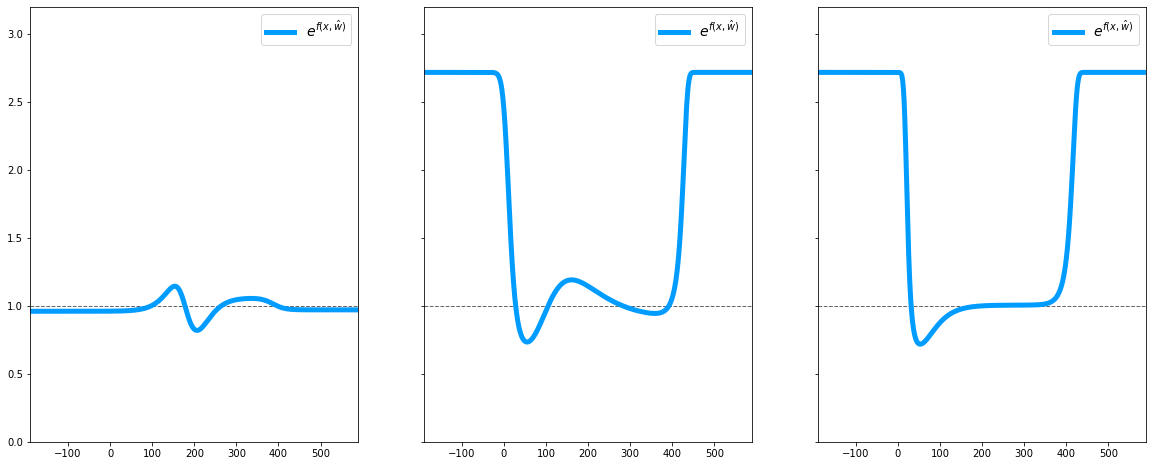

In [12]:
xgrid = np.linspace(-190, 590, 1000)

fig, ax = plt.subplots(ncols=3, figsize=(20,8), sharex="all", sharey="all")

ax[0].set_xlim(-190,590)
ax[0].set_ylim(0,3.2)
  
for i in [0, 1, 2]:
    
    ax[i].axhline(y=1, c="black", ls="--", lw=1, alpha=.6)
    
    sns.lineplot(
        x=xgrid,
        y=flatten(np.exp( models[i]((xgrid-means[i]) / stds[i]) )),
        linewidth=5,
        color="#009cff", 
        ax=ax[i],
        label=r"$e^{f(x, \hat{w})}$"
    )
    
    ax[i].legend(loc="upper right", fontsize=14)
    
plot_name = "predicted_ratio"
ext = "pdf"
fig.savefig(
    f"/lustre/cmswork/nlai/FALKON/plots/{plot_name}.{ext}",
    facecolor="white"
)     
plt.show()

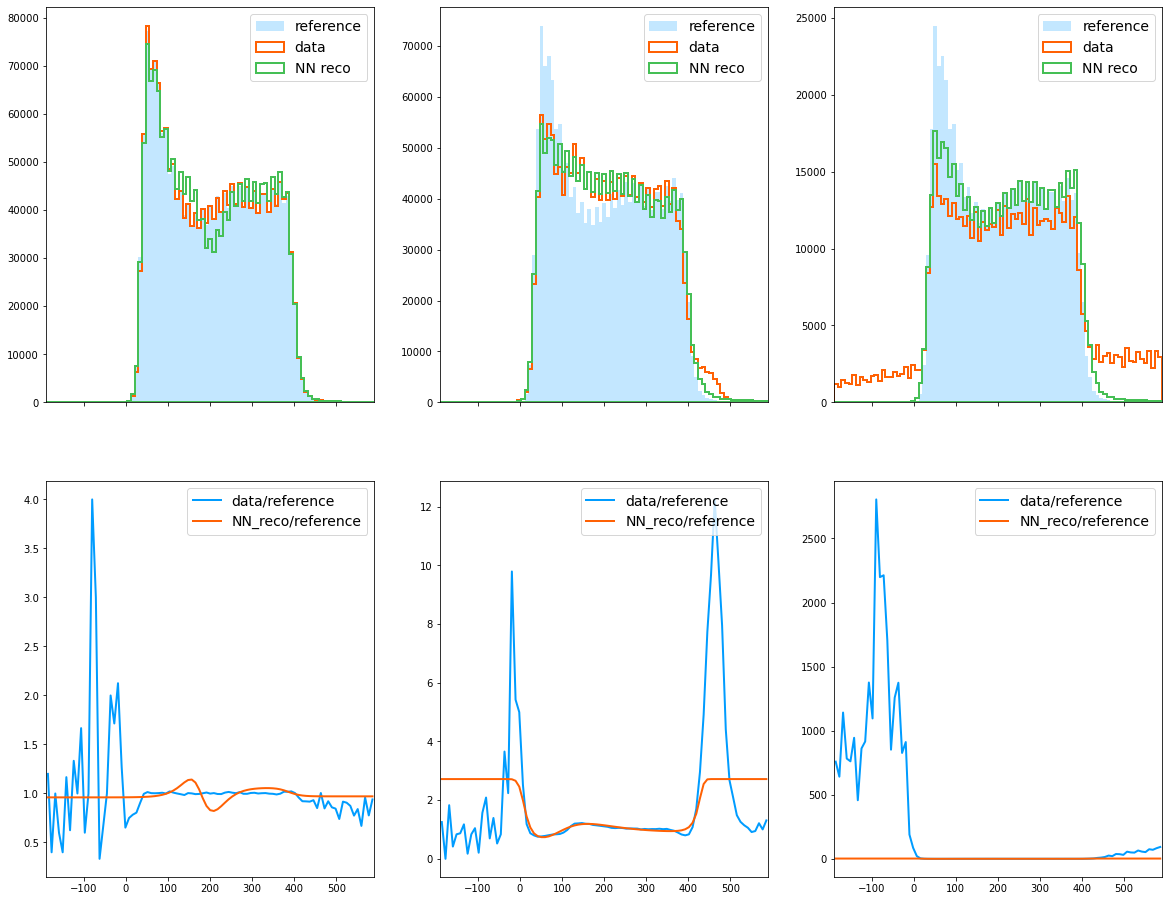

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,16), sharex="all")

ax[0][0].set_xlim(-190,590)
x = 0.5*(bins[1:]+bins[:-1])

for i in [0, 1, 2]:
    
    # reference distribution
    ref_hist = ax[0][i].hist(
        df_ref["drift_time"], 
        bins=bins, 
        weights=w_refs[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="none", 
        facecolor="#aadeff", 
        alpha=.7, 
        label="reference"
    )
    
    # data distribution
    data_hist = ax[0][i].hist(
        data_df[i]["drift_time"], 
        bins=bins, 
        weights=w_data[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="#FF6104", 
        facecolor="none", 
        alpha=1, 
        label="data"
    )
    
    # NN reco
    nn_hist = ax[0][i].hist(
        df_ref["drift_time"], 
        bins=bins, 
        weights=nn_weights[i]*w_refs[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="#45bf55", 
        facecolor="none", 
        alpha=1, 
        label="NN reco"
    )
    
    ax[0][i].legend(loc="upper right", fontsize=14)
    
    
    # data/ref ratio
    ax[1][i].plot(
        x, 
        (data_hist[0])/(ref_hist[0]),
        linewidth=2,
        color="#009cff", 
        alpha=1, 
        label="data/reference"
    )
    
    # NN_reco/ref ratio
    ax[1][i].plot(
        x, 
        (nn_hist[0])/(ref_hist[0]),
        linewidth=2,
        color="#FF6104", 
        alpha=1, 
        label="NN_reco/reference"
    )
    
    ax[1][i].legend(loc="upper right", fontsize=14)

plot_name = "nn_reco"
ext = "pdf"
fig.savefig(
    f"/lustre/cmswork/nlai/FALKON/plots/{plot_name}.{ext}",
    facecolor="white"
)     
plt.show()